# Восстановление золота из руды

Целью проекта является создание модели, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Процесс переработки состоит из 3 этапов: флотация, первичная очистка, вторичная очистка.

Данные содержат различные параметры для каждого этапа очистки.

## Подготовка данных

In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik
import random
import scipy.stats as st
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [215]:
warnings.filterwarnings('ignore')
sns.set()
sns.set_style("whitegrid")

In [216]:
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

*Проверим какие признаки есть в выборках*

In [217]:
len(data_full.columns)

87

In [218]:
len(data_train.columns)

87

In [219]:
len(data_test.columns)

53

In [220]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [221]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [222]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

*Из условия следует, что data_full содержит обе выборки. Поэтому исследуем ее, чтобы узнать правильно ли расчитанна recovery, какие признаки коррелируют с целевыми и прочее*

*Для начала подсчитаем пропуски и дубликаты*

In [223]:
pd.set_option('display.max_rows', None)
data_full.isna().sum().to_frame()

,0
date,0
final.output.concentrate_ag,1
final.output.concentrate_pb,1
final.output.concentrate_sol,211
final.output.concentrate_au,0
final.output.recovery,0
final.output.tail_ag,1
final.output.tail_pb,101
final.output.tail_sol,6
final.output.tail_au,0


In [224]:
pd.reset_option('display.max_rows')

In [225]:
data_full.duplicated().sum()

0

*В целом данные достаточно полные, без дубликатов. Единственное, что выбивается это secondary_cleaner.output.tail_sol с 1748 пропусками. Однако, в дальнейшем проверим нужен ли это столбец вообще для предсказания*

*Но для начала проверим, правильно ли считается recovery*

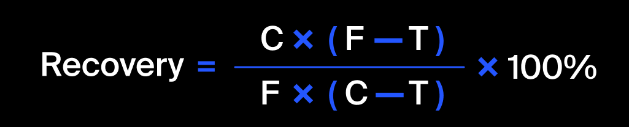

In [226]:
def recovery(per_before, per_after, per_tail):
    """
    The function calculate recovery for ore. Using percentage of metal before, after and in tails 
    """
    rec = per_after * (per_before - per_tail) / (per_before * (per_after - per_tail)) * 100
    return rec

In [227]:
rec = recovery(data_full['rougher.input.feed_au'], data_full['rougher.output.concentrate_au'], data_full['rougher.output.tail_au'])

In [228]:
mean_absolute_error(data_full['rougher.output.recovery'], rec)

9.874045668302637e-15

*Разница в recovery принебрежительна мала, что говорит о правильности расчета*

*Проверим признаки которых нет в тестовой выборке*

In [229]:
(set(data_full.columns) - set(data_test.columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

*В тетсовой выборке отсутсвуют выходы реакций после очисток и данные по применяемым химикатам. Самое главное, что в них отсутсвуют целевые признаки. Восстановим их используя дату*

In [230]:
data_test = data_test.merge(data_full[['date','rougher.output.recovery','final.output.recovery']],how='left',on='date')

In [231]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

*Теперь изучим распределение признаков, для начала изучим корреляцию*

In [232]:
f = data_full.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
t = data_full[['rougher.output.recovery','final.output.recovery']]

In [234]:
f.columns[f.columns.str.contains('final')]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol',
       'final.output.tail_au'],
      dtype='object')

interval columns not set, guessing: ['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'rougher.output.recovery', 'final.output.recovery']


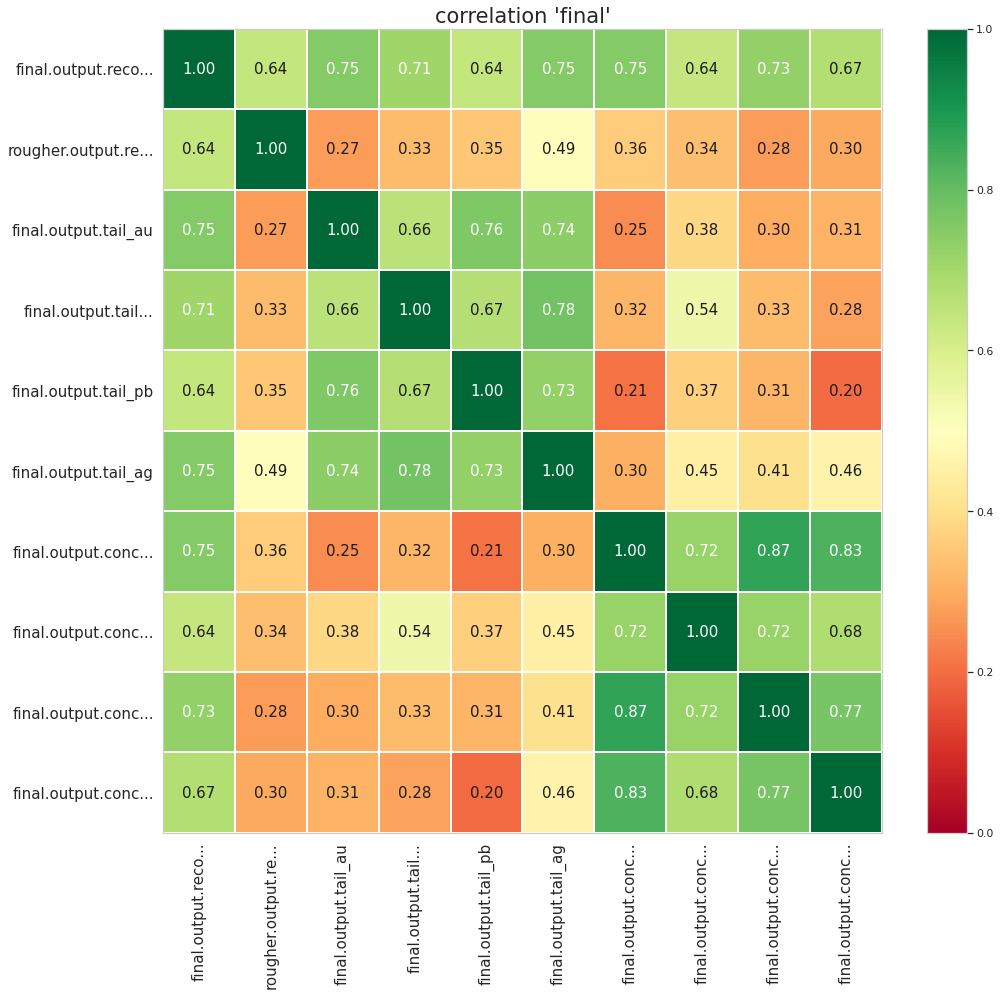

In [235]:
phik_overview = pd.concat([f[f.columns[f.columns.str.contains('final')]],t],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation 'final'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'rougher.output.recovery', 'final.output.recovery']


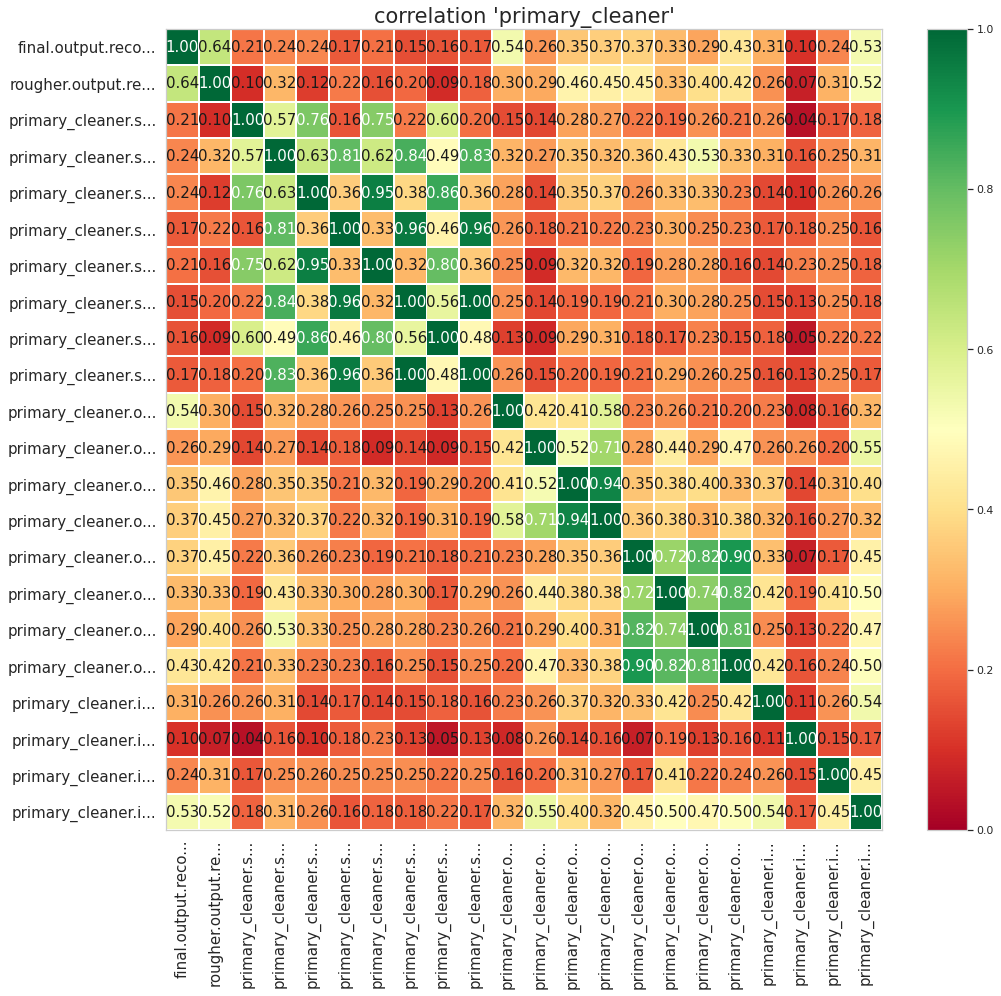

In [236]:
phik_overview = pd.concat([f[f.columns[f.columns.str.contains('primary_cleaner')]],t],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au', 'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level', 'rougher

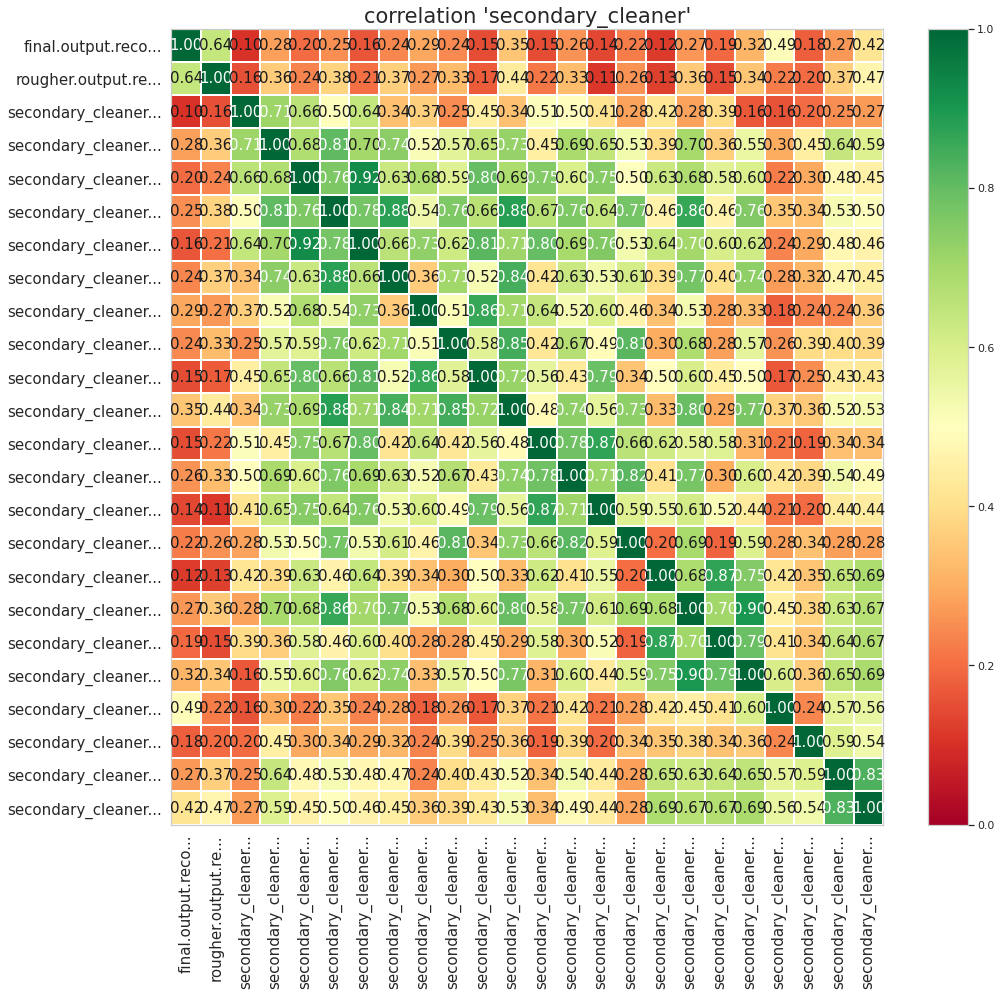

In [237]:
phik_overview = pd.concat([f[f.columns[f.columns.str.contains('secondary_cleaner')]],t],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation 'secondary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.sta

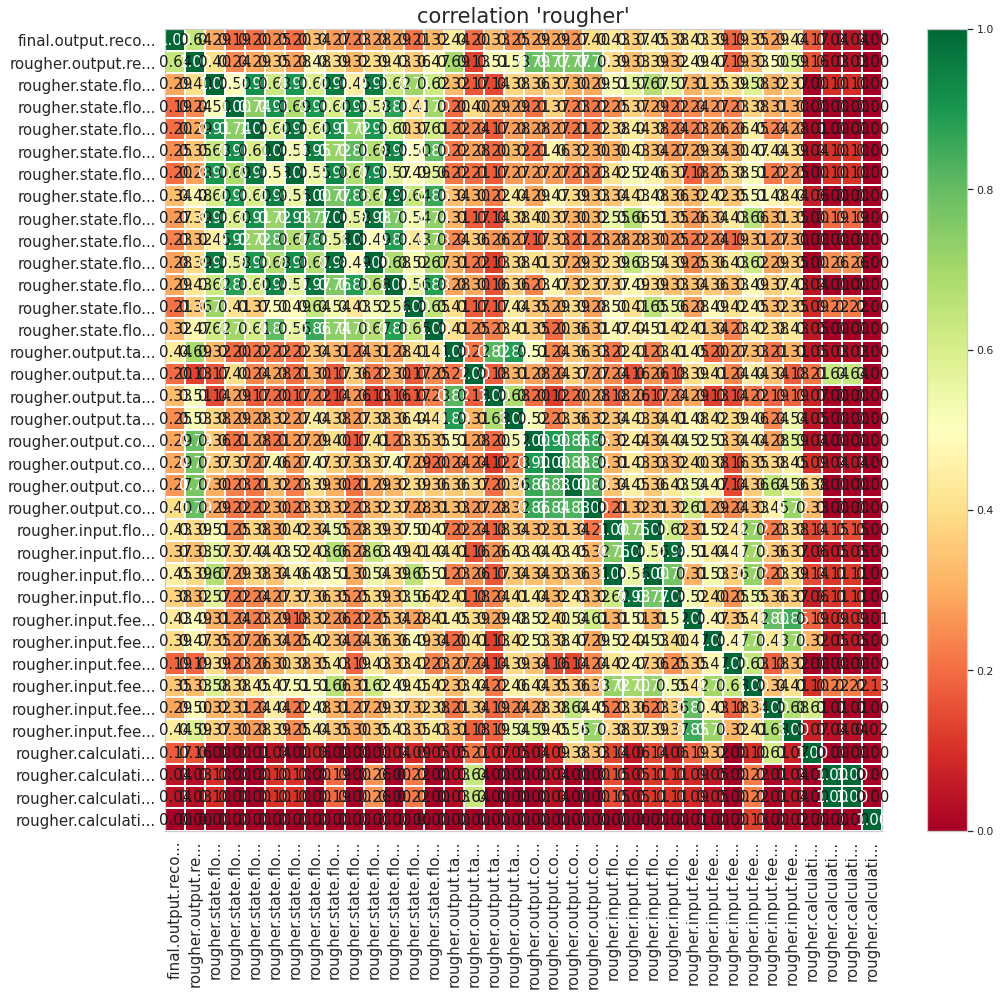

In [238]:
phik_overview = pd.concat([f[f.columns[f.columns.str.contains('rougher')]],t],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation 'rougher'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

*Мы видим что некоторые признаки очень сильно коррелируют, поэтому надо учитывать это при их отборе для обучения. Второе, так как в тестовой выборке нет части признаков, то их мы также удалим из общей и тренировочной выборках (из-за утечки целевого признака). Так же удалим все пропуски, их меньше 10% поэтому удаление допустимо*

In [239]:
data_full.dropna(inplace=True)
data_train.dropna(inplace=True)
data_test.dropna(inplace=True)

In [240]:
df_full = data_full[data_test.columns]
df_train = data_train[data_test.columns]
df_test = data_test[data_test.columns]

*Подготовим данные для обучения. Для выхода реакции после флотации, мы можем использовать данные только до этого процесса, следовательно, только параметры сырья и состояния, то есть rougher.input и rougher.state. По аналогии сделаем также для финальной выборки, также учтем, что признаки rougher.calculation почти не коррелируют с целевыми признаками.*

In [241]:
index_rougher = df_train.columns[df_train.columns.str.contains('rougher.input|rougher.state|data')]
features_rougher = df_train[index_rougher]
target_rougher = df_train[['rougher.output.recovery']]
features_rougher_test = df_test[index_rougher]
target_rougher_test = df_test[['rougher.output.recovery']]

In [242]:
index_final = df_train.columns[df_train.columns.str.contains('final.output|date')]
features = df_train.drop(index_final,axis=1)
target = df_train[['final.output.recovery']]
features_test = df_test.drop(index_final,axis=1)
target_test = df_test[['final.output.recovery']]

## Анализ данных

*Постоим распределения концентраций металлов после разных этапов очистки* 

In [243]:
l = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']
metal_list = ['ag','pb','au']
color = ['yellow','']

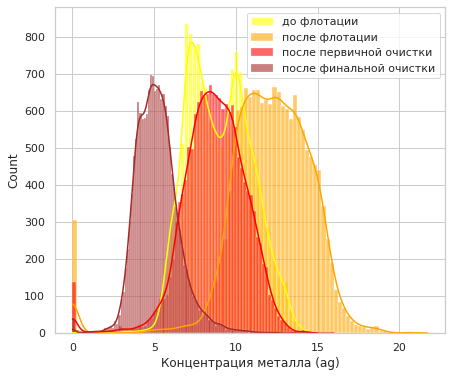

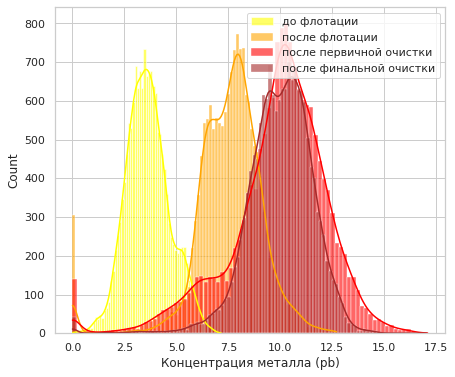

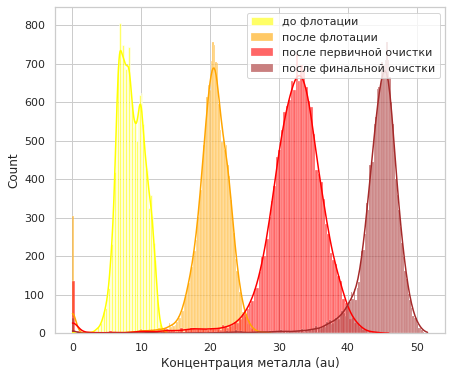

In [244]:
for metal in metal_list:
    plt.figure(figsize=(7, 6))
    sns.histplot(data_full,x=l[0]+metal,label='до флотации',color='yellow',kde=True,alpha=.6)
    sns.histplot(data_full,x=l[1]+metal,label='после флотации',color='orange',kde=True,alpha=.6)
    sns.histplot(data_full,x=l[2]+metal,label='после первичной очистки',color='red',kde=True,alpha=.6)
    sns.histplot(data_full,x=l[3]+metal,label='после финальной очистки',color='brown',kde=True,alpha=.6)
    plt.xlabel(f'Концентрация металла ({metal})')
    plt.legend()
    plt.show()

**Вывод: Только концентрация золота увеличивается при очистке, причем в 5 раз. Концентрация свинца не увеличивалась после первичной очистки, а у серебра после всего цикла уменьшилась. Также видно, что после обработки возникают пики в области нулей. Они могут возникнуть из-за неправильного химпроцесса, что стоит также заложить в модель или отображают вероятность пустой породы. Поэтому оставим их.**

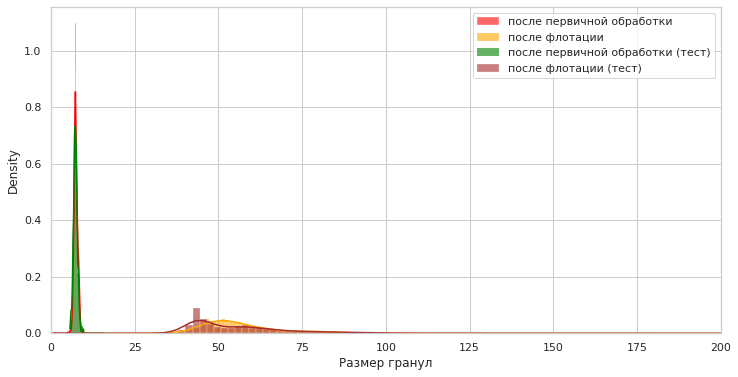

In [245]:
size = f.columns[f.columns.str.contains('size')]
plt.figure(figsize=(12, 6))
sns.histplot(data_train,x=size[0],label='после первичной обработки',color='red',kde=True,alpha=.6,stat='density')
sns.histplot(data_train,x=size[1],label='после флотации',color='orange',kde=True,alpha=.6,stat='density')
sns.histplot(data_test,x=size[0],label='после первичной обработки (тест)',color='green',kde=True,alpha=.6,stat='density')
sns.histplot(data_test,x=size[1],label='после флотации (тест)',color='brown',kde=True,alpha=.6,stat='density')
plt.xlabel('Размер гранул')
plt.legend()
plt.xlim([0,200])
plt.show()

In [246]:
f.columns[f.columns.str.contains('size')]

Index(['primary_cleaner.input.feed_size', 'rougher.input.feed_size'], dtype='object')

In [247]:
st.ttest_ind(data_train['primary_cleaner.input.feed_size'],data_test['primary_cleaner.input.feed_size'])

Ttest_indResult(statistic=12.66490737306463, pvalue=1.3779981880710514e-36)

In [248]:
st.ttest_ind(data_train['rougher.input.feed_size'],data_test['rougher.input.feed_size'])

Ttest_indResult(statistic=4.253987977556823, pvalue=2.1117214581598514e-05)

**Вывод: размер гранул в тестовой и тренировочной выборках статистически неразличимы**

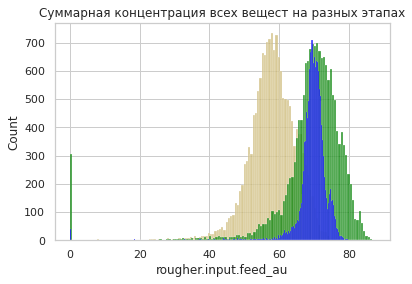

In [249]:
sum_rougher_input = 0
sum_rougher_output = 0
sum_final = 0
for metal in ['au', 'ag', 'pb', 'sol']:
    sum_rougher_input += data_full[f'rougher.input.feed_{metal}']
    sum_rougher_output += data_full[f'rougher.output.concentrate_{metal}']
    sum_final += data_full[f'final.output.concentrate_{metal}']
sns.histplot(sum_rougher_input, color='y', label='первоначально')
sns.histplot(sum_rougher_output, color='green', label='после флотации')
sns.histplot(sum_final, color='blue', label='после финальной очистки')
plt.title('Суммарная концентрация всех вещест на разных этапах')
plt.show()

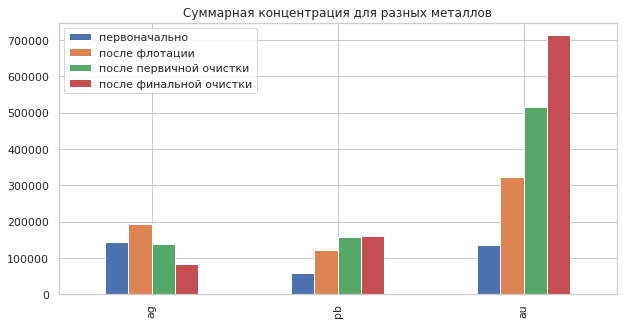

In [250]:
l = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']
metal_list = ['ag','pb','au']
name = ['первоначально','после флотации','после первичной очистки','после финальной очистки']
a = []
for metal in metal_list:   
    for i in l:
        a.append(data_full[[i+metal]].values.sum())
df_sum_con = pd.DataFrame([a[:4],a[4:8],a[8:]],index=metal_list,columns=name)
df_sum_con.plot(kind='bar',figsize=(10,5))
plt.title('Суммарная концентрация для разных металлов')
plt.show()

In [251]:
df_sum_con

,первоначально,после флотации,после первичной очистки,после финальной очистки
ag,144609.108070,194495.102551,139613.083984,83543.562649
pb,58527.783485,121559.514010,159073.388967,160901.269276
au,137072.441231,322719.333964,516063.108326,713083.897490


**Вывод: суммарная концентрация растет для золота и свинца в процессе очистки, у золота конечная концентрация увеличилась в 6 раз по сравнению с первоначальной. Значения серебра после флотации начали уменьшаться. После каждого этапа очистки разброс концентраций уменьшается, что отчетливо видно на графике**

## Модель

*Построим модели линейноу регрессии и случайного леса. Начнем с линейно регрессии, но перед этим зададим оценочную функцию*

In [252]:
def smape(predict, target):
    smape =  1 / len(predict) * np.sum((np.abs(target - predict)/ ((np.abs(target) + np.abs(predict)) / 2))) * 100
    return -1 * smape

def modified_smape(rougher: float, final: float):
    return -(0.25 * rougher + 0.75 * final)

smape_scorer = make_scorer(smape, greater_is_better = False)

In [280]:
model_rougher = LinearRegression()
smape_rougher = cross_val_score(model_rougher,
                                features_rougher,
                                target_rougher,
                                scoring=smape_scorer,
                                cv=10)
print("Mean score: ", smape_rougher.mean())
print("Standard deviation: ", smape_rougher.std())

Mean score:  9.718238291533336
Standard deviation:  4.144284228915513


In [281]:
model_final = LinearRegression()
smape_final = cross_val_score(model_final,
                        features,
                        target,
                        scoring=smape_scorer,
                        cv=10)
print("Mean score: ", smape_final.mean())
print("Standard deviation: ", smape_final.std())

Mean score:  8.99316712812848
Standard deviation:  1.3864807538204502


In [282]:
predict_rougher = model_rougher.fit(features_rougher,target_rougher).predict(features_rougher_test)
rougher_smape = smape(predict_rougher, target_rougher_test)
print(-rougher_smape)

rougher.output.recovery    9.318011
dtype: float64


In [283]:
predict = model_final.fit(features,target).predict(features_test)
final_smape = smape(predict, target_test)
print(-final_smape)

final.output.recovery    8.44116
dtype: float64


In [274]:
modified_smape(rougher_smape[0], final_smape[0])

8.66037279348756

*Вывод: линейная регрессия показала итоговую SMAPE в районе 8,7. Логично, что предсказания для флотации хуже из-за меньшего количества признаков.*

*Рассмотрим случайный лес*

In [258]:
m1 = RandomForestRegressor(random_state=123)
parameters = {'n_estimators':[10,100,10], 'max_depth':[3,30,2]}
gs_f1 = GridSearchCV(m1,
                     parameters,
                     scoring=smape_scorer
                    )
gs_f1.fit(features_rougher, target_rougher)
gs_f1.best_params_

{'max_depth': 3, 'n_estimators': 10}

In [259]:
gs_f1.fit(features, target)
gs_f1.best_params_

{'max_depth': 3, 'n_estimators': 10}

In [284]:
model = RandomForestRegressor(max_depth=3, n_estimators=10, random_state=123)
predict = model.fit(features_rougher,target_rougher).predict(features_rougher_test)
rougher_smape_rf = smape(predict, target_rougher_test['rougher.output.recovery'])
print('SMAPE для флотации')
print(-rougher_smape_rf)
predict = model.fit(features,target).predict(features_test)
final_smape_rf = smape(predict, target_test['final.output.recovery'])
print('SMAPE для финальной очистки')
print(-final_smape_rf)

SMAPE для флотации
10.439827744306301
SMAPE для финальной очистки
7.609863008405658


In [285]:
round(modified_smape(rougher_smape_rf,final_smape_rf),2)

8.32

*Вывод: показатель  SMAPE случайного леса для флтотации значительно хуже - 10,4, однако за счет лучшего для финальной очистки 7,6% итоговая также 8,3%. Поэтому будем использовать линейный регрессор для первой ступени очистки и лес для финальной. Посчитаем итоговый SMAPE для такого рассклада*

In [287]:
round(modified_smape(rougher_smape,final_smape_rf)[0],2)

8.04

*Проверим адектваность нашей модели*

In [288]:
dummy_model = DummyRegressor(strategy="mean")
predict_dummy = model.fit(features_rougher,target_rougher).predict(features_rougher_test)
dummy_rougher_smape_rf = smape(predict_dummy, target_rougher_test['rougher.output.recovery'])
print('SMAPE для флотации')
print(-dummy_rougher_smape_rf)
predict_dummy = dummy_model.fit(features,target).predict(features_test)
dummy_final_smape_rf = smape(predict_dummy, target_test['final.output.recovery'])
print('SMAPE для финальной очистки')
print(-dummy_final_smape_rf)

SMAPE для флотации
10.439827744306301
SMAPE для финальной очистки
9.56858357360044


In [289]:
round(modified_smape(dummy_rougher_smape_rf,dummy_final_smape_rf),2)

9.79

**Вывод: в ходе проекта была осуществлена предобработка и анализ данных. Исследование концентраций металлов на разных этапах показало, что концентрация золота росла от этапа к этапу при этом распределение сужалось. Также стоит обратить внимание на наличие нулей в дата сете, что может говорить о наличии пустой породы, ошибке заполнения данных или нарушении химпроцесса. Наилучшим подходом стало применение модели линейной регрессии для флотации и случайного леса для финальной очистки.**